In [1]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import numpy as np

import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from models import VGG16, ResNet18

from solvers import *

import cupy as cp
from scipy.linalg import eigh

/opt/mambaforge/envs/landing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 2*1024

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=False, transform=transform)

transform_MNIST = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset_MNIST = torchvision.datasets.MNIST(root='data', download=True, train=True, transform=transform_MNIST)

trainloader_MNIST = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
def VectorizeLeftImage(batch):
    data = [item[0][:,:,:14].reshape(-1).unsqueeze(0) for item in batch]
    return(torch.cat(data, dim = 0))

def VectorizeRightImage(batch):
    data = [item[0][:,:,14:].reshape(-1).unsqueeze(0) for item in batch]
    return(torch.cat(data, dim = 0))

loader_A = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=VectorizeLeftImage)
loader_B = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=VectorizeRightImage)

In [4]:
X, Y, covA, covB, covAB, out  = LandingCCA(loader_A, loader_B, p = 5, learning_rate = 1e-2, omega = 10,  n_epochs=150, device = torch.device('cuda'))
#learning_rate = 1e-3, omega = 100,

Dist X: 1.88677
Dist X: 1.88723
Objective: -1.43049
Dist X: 1.09321
Dist Y: 0.88261
Objective: -2.01677
Dist X: 0.67351
Dist Y: 0.87598
Objective: -2.32416
Dist X: 0.64894
Dist Y: 0.78824
Objective: -2.48953
Dist X: 0.65412
Dist Y: 0.74235
Objective: -2.62008
Dist X: 0.66227
Dist Y: 0.70414
Objective: -2.73890
Dist X: 0.66100
Dist Y: 0.67055
Objective: -2.84434
Dist X: 0.65281
Dist Y: 0.64408
Objective: -2.93489
Dist X: 0.64164
Dist Y: 0.62430
Objective: -3.01168
Dist X: 0.62975
Dist Y: 0.60908
Objective: -3.07680
Dist X: 0.61818
Dist Y: 0.59644
Objective: -3.13240
Dist X: 0.60730
Dist Y: 0.58511
Objective: -3.18035
Dist X: 0.59720
Dist Y: 0.57443
Objective: -3.22219
Dist X: 0.58783
Dist Y: 0.56412
Objective: -3.25912
Dist X: 0.57909
Dist Y: 0.55406
Objective: -3.29208
Dist X: 0.57089
Dist Y: 0.54425
Objective: -3.32181
Dist X: 0.56314
Dist Y: 0.53470
Objective: -3.34886
Dist X: 0.55576
Dist Y: 0.52543
Objective: -3.37365
Dist X: 0.54870
Dist Y: 0.51645
Objective: -3.39652
Dist X: 0.54

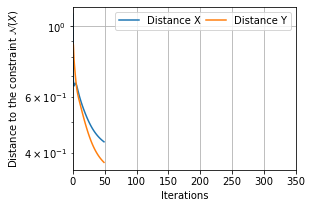

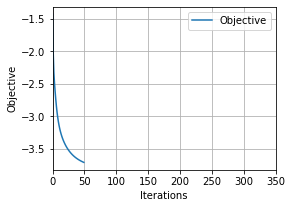

In [5]:
plt.figure(figsize=(4, 3))
plt.semilogy(out['distanceX'], label = 'Distance X')
plt.semilogy(out['distanceY'], label = 'Distance Y')
plt.xlim([0, 350])
x_ = plt.xlabel('Iterations')
y_ = plt.ylabel('Distance to the constraint $\mathcal{N}(X)$')
plt.grid()
plt.legend(ncol=2, loc='upper right', columnspacing=.5, handlelength=2)
plt.show()
#plt.savefig('cca_distance.pdf', bbox_inches='tight', bbox_extra_artists=(x_, y_))

plt.figure(figsize=(4, 3))
plt.plot(np.array(out['objective']), label='Objective')
plt.xlim([0, 350])
x_ = plt.xlabel('Iterations')
y_ = plt.ylabel('Objective')
plt.legend(ncol=2, loc='upper right', columnspacing=.5, handlelength=2)

plt.grid()
plt.show()
#plt.savefig('cca_objective.pdf', bbox_inches='tight', bbox_extra_artists=(x_, y_))

In [10]:
X = X.detach()
Y = Y.detach()

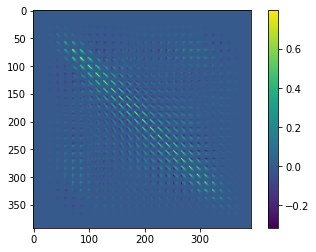

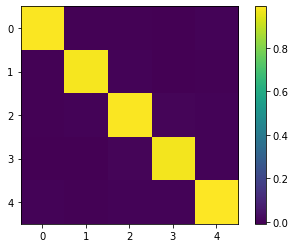

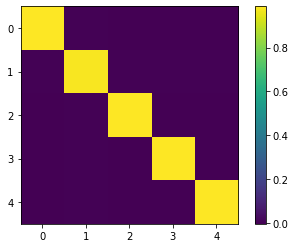

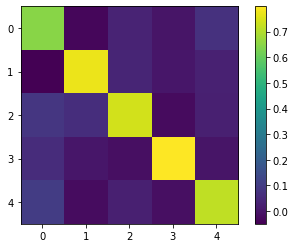

In [11]:
plt.imshow(BtB_full.to('cpu').numpy())
plt.colorbar()
plt.show()

plt.imshow((X.T @ AtA_full @ X).to('cpu').numpy())
plt.colorbar()
plt.show()

plt.imshow((Y.T @ BtB_full @ Y).to('cpu').numpy())
plt.colorbar()
plt.show()

plt.imshow((X.T @ AtB_full @ Y).to('cpu').numpy())
plt.colorbar()
plt.show()

In [13]:
covA, covB, covAB = loader_to_cov(loader_A, loader_B,device = 'cuda')

In [14]:
u2, s, v2 = cca_closed_form(covA, covB, covAB, epsilon=1e-3, verb = True)

adding eps to diagonal and taking inverse
taking square root
dot products...
trying to take final svd
computed everything!


In [15]:
u3, s3, v3, covA_lr = svcca(covA, covB, covAB, 20,epsilon=1e-3, verb=False)

In [17]:
torch.trace(u3[:,:5].T @ covAB @ v3[:,:5])

tensor(3.5696, device='cuda:0')

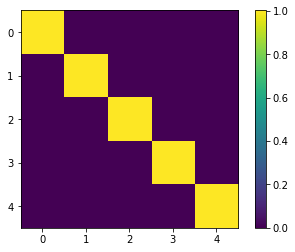

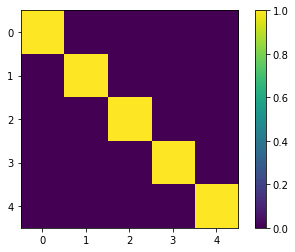

In [131]:
t = (u2[:,:5].T @ (covA) @ u2[:,:5] )
plt.imshow(t.to('cpu').numpy())
plt.colorbar()
plt.show()

t = (u3[:,:5].T @ (covA) @ u3[:,:5] )
plt.imshow(t.to('cpu').numpy())
plt.colorbar()
plt.show()

In [132]:
torch.trace(u3[:,:5].T @ covAB @ v3[:,:5])

tensor(2.4585, device='cuda:0')

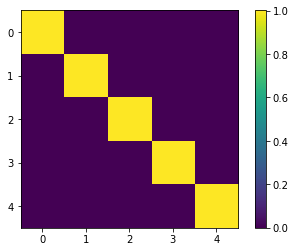

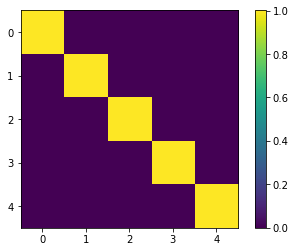

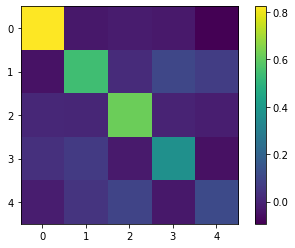

In [123]:
t = (u3[:,:5].T @ (covA+ 0*torch.eye(covA.size(0),device = 'cuda')) @ u3[:,:5] )
plt.imshow(t.to('cpu').numpy())
plt.colorbar()
plt.show()

t = v3[:,:5].T @ covB @ v3[:,:5]
plt.imshow(t.to('cpu').numpy())
plt.colorbar()
plt.show()

t = u3[:,:5].T @ covAB @ v3[:,:5]
plt.imshow(t.to('cpu').numpy())
plt.colorbar()
plt.show()

In [73]:
-.5*torch.trace(u[:,:5].T @ covAB @ v2[:,:5])

tensor(-5.1856, device='cuda:0')

In [38]:
s[]

tensor([9.5715e-01, 9.5101e-01, 9.4251e-01, 9.3523e-01, 9.2088e-01, 9.0934e-01,
        8.8670e-01, 8.7153e-01, 8.6323e-01, 8.4781e-01, 8.2756e-01, 7.9694e-01,
        7.9582e-01, 7.7435e-01, 7.1616e-01, 6.9989e-01, 6.7249e-01, 6.4909e-01,
        6.1516e-01, 6.0704e-01, 6.0128e-01, 5.6698e-01, 5.6296e-01, 5.4830e-01,
        5.2868e-01, 5.2117e-01, 5.0359e-01, 4.9318e-01, 4.7748e-01, 4.6498e-01,
        4.4853e-01, 4.3690e-01, 4.1060e-01, 4.0842e-01, 4.0235e-01, 3.7984e-01,
        3.6849e-01, 3.4648e-01, 3.3081e-01, 3.2615e-01, 3.2344e-01, 3.0239e-01,
        2.9616e-01, 2.8004e-01, 2.6412e-01, 2.6223e-01, 2.5506e-01, 2.4749e-01,
        2.3632e-01, 2.2991e-01, 2.2095e-01, 2.1566e-01, 2.1178e-01, 2.0379e-01,
        1.9978e-01, 1.9227e-01, 1.8859e-01, 1.8609e-01, 1.8329e-01, 1.7779e-01,
        1.7107e-01, 1.6841e-01, 1.6377e-01, 1.6031e-01, 1.5616e-01, 1.5267e-01,
        1.4768e-01, 1.4719e-01, 1.4493e-01, 1.4224e-01, 1.3870e-01, 1.3528e-01,
        1.3511e-01, 1.3339e-01, 1.3154e-

In [39]:
def eval_CCA(covA, covB, covAB, num_components, eps):
    evals_covA, evecs_covA = torch.linalg.eigh(covA + eps*torch.eye(covA.size(0), device= covA.device))
    evals_covB, evecs_covB = torch.linalg.eigh(covB + eps*torch.eye(covB.size(0), device= covA.device))
    covA_isqrt = evecs_covA @ torch.diag(evals_covA**(-0.5)) @ evecs_covA.T
    covB_isqrt = evecs_covB @ torch.diag(evals_covB**(-0.5)) @ evecs_covB.T
    u, s, v = torch.linalg.svd(covA_isqrt @ covAB @ covB_isqrt, full_matrices = False)
    x_true = u[:,:num_components]
    xy_corr = s[:num_components]
    y_true = v[:num_components,:].T
    return(x_true, y_true, xy_corr)

SyntaxError: invalid syntax (1910750013.py, line 1)

In [15]:
covA, covB, covAB = loader_to_cov(loader_A, loader_B,device = 'cuda')

ValueError: too many values to unpack (expected 2)

In [9]:
x_true, y_true, xy_corr = eval_CCA(AtA_full, BtB_full, AtB_full, 10, eps = 1e-5)
x_true = x_true.cpu().numpy()
y_true = y_true.cpu().numpy()

In [23]:
np.trace(x_true.T @ AtB @ y_true )

302.72025

In [11]:
np.trace(X_cpu.T @ AtB @ Y_cpu )

0.93079555

In [24]:
np.linalg.norm(x_true.T @ AtA @ x_true - np.eye(x_true.shape[1]))

266.71440591739673

In [25]:
np.linalg.norm(X_cpu.T @ AtA @ X_cpu - np.eye(X_cpu.shape[1]))

1.9673596152934258

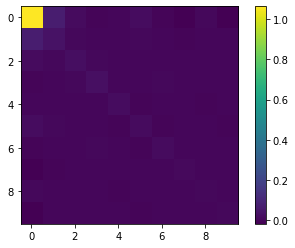

In [30]:
plt.imshow(x_true.T @ AtA @ x_true/250 )
plt.colorbar()

In [17]:
X_cpu.shape

(392, 5)

In [71]:
ind = 1
plt.imshow(np.hstack((x_true[:,ind].reshape(28,14), X_cpu[:,ind].reshape(28,14))))
plt.show()
plt.imshow(np.hstack((y_true[:,ind].reshape(28,14), Y_cpu[:,ind].reshape(28,14))))
plt.show()

NameError: name 'x_true' is not defined

In [14]:
np.trace(x_true.T @ AtB @ y_true)

286.57953

In [15]:
torch.linalg.norm(AtB_full)

tensor(258.4471, device='cuda:0')

In [16]:
torch.trace(X.T @ AtB_full @ Y)

tensor(3.4283, device='cuda:0', grad_fn=<TraceBackward0>)

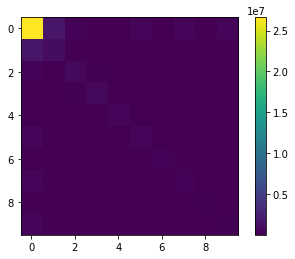

In [36]:
plt.imshow(np.abs(x_true.T @ (AtA +1e-5* np.eye(AtA.shape[0]))@ x_true)/1e-5)
plt.colorbar()


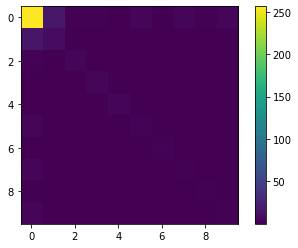

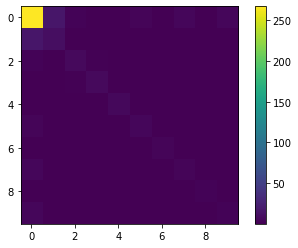

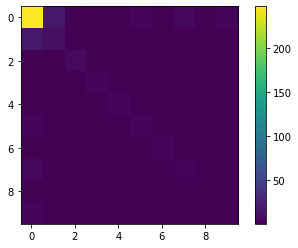

In [26]:
plt.imshow(np.abs(x_true.T @ AtB @ y_true))
plt.colorbar()
plt.show()
plt.imshow(np.abs(x_true.T @ (AtA + np.eye(AtA.shape[0]))@ x_true))
plt.colorbar()
plt.show()
plt.imshow(np.abs(y_true.T @ BtB @ y_true))
plt.colorbar()
plt.show()

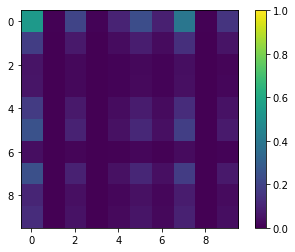

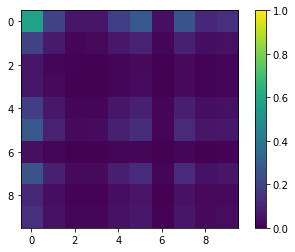

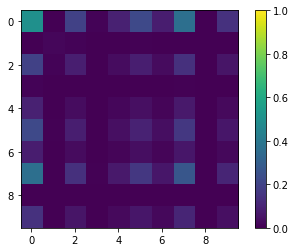

In [21]:
plt.imshow(np.abs(X_cpu.T @ AtB @ Y_cpu), clim=[0,1])
plt.colorbar()
plt.show()
plt.imshow(np.abs(X_cpu.T @ AtA @ X_cpu), clim=[0,1])
plt.colorbar()
plt.show()
plt.imshow(np.abs(Y_cpu.T @ BtB @ Y_cpu), clim=[0,1])
plt.colorbar()
plt.show()

In [13]:
etmp, _ = np.linalg.eig(AtA - np.eye(392))

In [15]:
etmp

array([ 2.66689097e+02+0.0000000e+00j,  9.43700916e+00+0.0000000e+00j,
        8.70814200e+00+0.0000000e+00j,  7.32059792e+00+0.0000000e+00j,
        6.66185297e+00+0.0000000e+00j,  5.01854101e+00+0.0000000e+00j,
        4.05924116e+00+0.0000000e+00j,  2.72082343e+00+0.0000000e+00j,
        2.36344196e+00+0.0000000e+00j,  1.95435479e+00+0.0000000e+00j,
        1.57381174e+00+0.0000000e+00j,  1.37952409e+00+0.0000000e+00j,
        1.06334154e+00+0.0000000e+00j,  1.00946705e+00+0.0000000e+00j,
        6.99567605e-01+0.0000000e+00j,  6.22834248e-01+0.0000000e+00j,
        4.86948107e-01+0.0000000e+00j,  2.85375365e-01+0.0000000e+00j,
        1.96197248e-01+0.0000000e+00j,  1.72451268e-01+0.0000000e+00j,
        2.67297552e-02+0.0000000e+00j,  4.09396356e-03+0.0000000e+00j,
       -1.25836575e-01+0.0000000e+00j, -1.51021580e-01+0.0000000e+00j,
       -2.28162298e-01+0.0000000e+00j, -2.50873026e-01+0.0000000e+00j,
       -3.42771064e-01+0.0000000e+00j, -3.90080180e-01+0.0000000e+00j,
      

/opt/mambaforge/envs/landing/lib/python3.8/site-packages/numpy/lib/histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/opt/mambaforge/envs/landing/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6740: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([391.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ -1.00000004,  25.7689097 ,  52.53781943,  79.30672917,
        106.0756389 , 132.84454864, 159.61345838, 186.38236811,
        213.15127785, 239.92018759, 266.68909732]),
 <BarContainer object of 10 artists>)

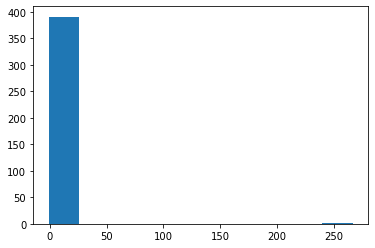

In [14]:
plt.hist(etmp)

In [6]:
AtAinv = np.linalg.inv(AtA+0.000005*np.eye(392,392))
BtBinv = np.linalg.inv(BtB+0.000005*np.eye(392,392))

In [7]:
# True solution:
d, u  = np.linalg.eig(AtAinv@AtB@BtBinv@AtB.T)
u1 = u[:,:10]
d, u  = np.linalg.eig(BtBinv@AtB.T@AtAinv@AtB)
u2 = u[:,:10]

In [8]:
u.shape

(392, 392)

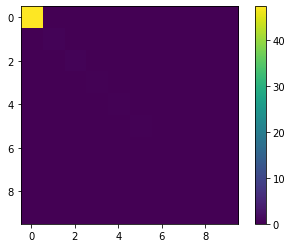

In [9]:
plt.imshow(np.abs(u1.T @ AtB @ u2))
plt.colorbar()

In [10]:
plt.rcParams.update({'text.usetex' : True})

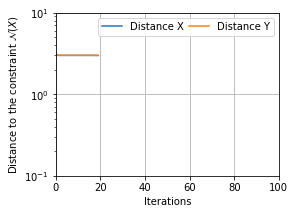

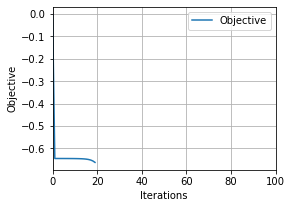

In [15]:
plt.figure(figsize=(4, 3))
plt.semilogy(out['distanceX'], label = 'Distance X')
plt.semilogy(out['distanceY'], label = 'Distance Y')
plt.xlim([0, 100])
plt.ylim([1e-1, 1e1])
x_ = plt.xlabel('Iterations')
y_ = plt.ylabel('Distance to the constraint $\mathcal{N}(X)$')
plt.grid()
plt.legend(ncol=2, loc='upper right', columnspacing=.5, handlelength=2)
plt.show()
#plt.savefig('cca_distance.pdf', bbox_inches='tight', bbox_extra_artists=(x_, y_))

plt.figure(figsize=(4, 3))
plt.plot(np.array(out['objective']), label='Objective')
plt.xlim([0, 100])
x_ = plt.xlabel('Iterations')
y_ = plt.ylabel('Objective')
plt.legend(ncol=2, loc='upper right', columnspacing=.5, handlelength=2)

plt.grid()
plt.show()
#plt.savefig('cca_objective.pdf', bbox_inches='tight', bbox_extra_artists=(x_, y_))



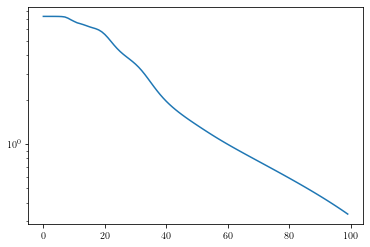

In [20]:
plt.semilogy(np.array(out['objective'])+7.5)

In [27]:
AtA = AtA_full.cpu().numpy()
BtB = BtB_full.cpu().numpy()
AtB = AtB_full.cpu().numpy()

X_cpu = X.detach().cpu().numpy()
Y_cpu = Y.detach().cpu().numpy()

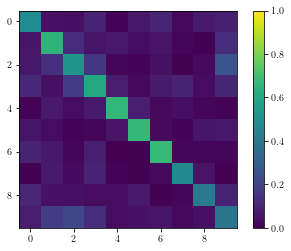

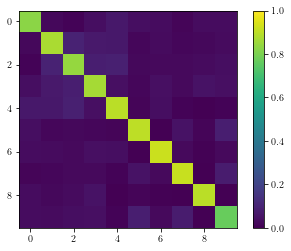

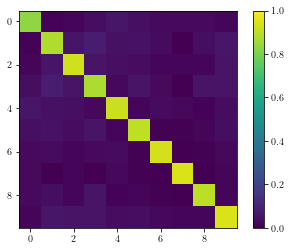

In [12]:
plt.imshow(np.abs(X_cpu.T @ AtB @ Y_cpu), clim=[0,1])
plt.colorbar()
plt.show()
plt.imshow(np.abs(X_cpu.T @ AtA @ X_cpu), clim=[0,1])
plt.colorbar()
plt.show()
plt.imshow(np.abs(Y_cpu.T @ BtB @ Y_cpu), clim=[0,1])
plt.colorbar()
plt.show()

In [25]:
np.linalg.norm(np.diag(AtB))

12.141672

In [27]:
AtB.shape

(392, 392)

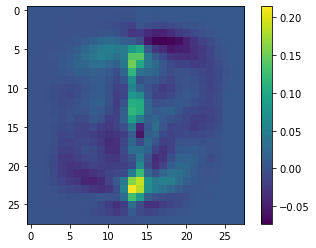

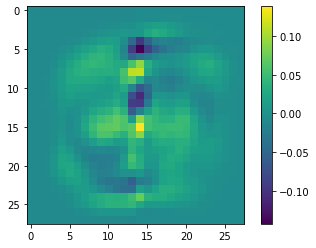

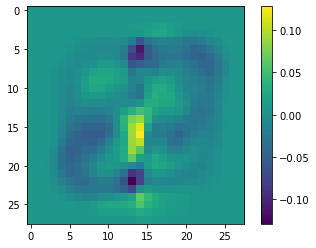

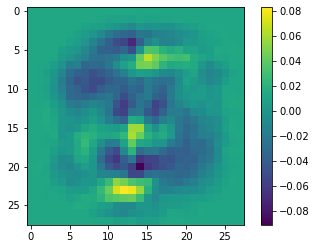

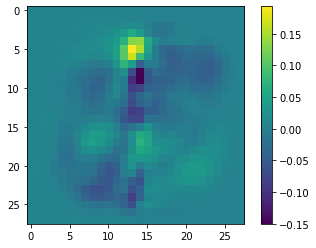

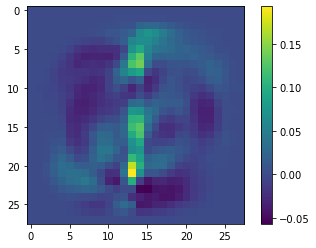

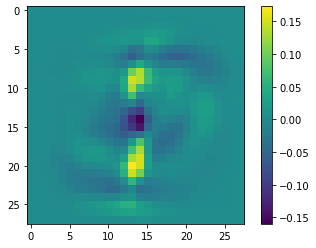

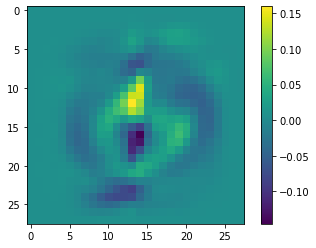

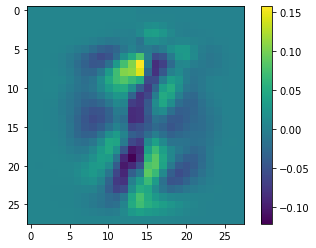

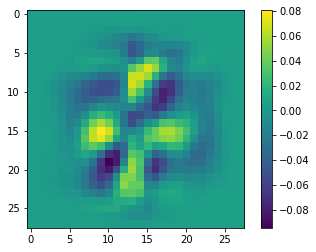

In [13]:
for i in range(10):
    x_tmp = (X_cpu[:,i]).reshape(28,-1)
    y_tmp = (Y_cpu[:,i]).reshape(28,-1)
    plt.imshow(np.concatenate([x_tmp,y_tmp],axis=1))
    plt.colorbar()
    plt.show()

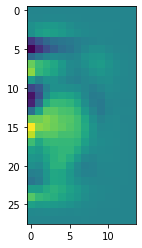

In [20]:
plt.imshow((Y_cpu[:,1]).reshape(28,-1))

In [8]:
(AtA@X_cpu).shape

(392, 10)

In [9]:
((AtA@X_cpu) @ (X_cpu.T @ AtA @ X_cpu - np.eye(10,10)))

array([[  920.11036875, -2085.72863305,    73.47406366, ...,
          -51.14708096,  -130.66572299,   723.7861788 ],
       [  920.11036875, -2085.72863305,    73.47406366, ...,
          -51.14708096,  -130.66572299,   723.7861788 ],
       [  920.11036875, -2085.72863305,    73.47406366, ...,
          -51.14708096,  -130.66572299,   723.7861788 ],
       ...,
       [  924.12707451, -2077.03577179,    83.54595979, ...,
          -53.66739613,  -124.3442831 ,   724.10880686],
       [  925.05992824, -2072.99607729,    85.97999375, ...,
          -55.178644  ,  -122.47910508,   723.33150251],
       [  925.23880473, -2069.96477653,    87.36572159, ...,
          -56.11967307,  -121.45809028,   722.52802804]])

In [ ]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(np.abs((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy()))
plt.colorbar()
plt.show()

print(torch.diag((features1 @ Q1).T @ (features2 @ Q2)))

In [3]:
n_epochs = 15
device = 'cuda'

model1 = VGG16()
model1.to(device)

optimizer1 = optim.SGD(model1.parameters(), lr=1e-1, weight_decay=5e-4)

model2 = VGG16()
model2.to(device)

optimizer2 = optim.SGD(model2.parameters(), lr=1e-1, weight_decay=5e-4)


In [4]:
def train(model, optimizer, n_epochs):
    best_test_acc = 0.
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            loss = model.loss(logits, batch_y)
            train_loss =+ loss.item() * batch_x.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(train_loss)

        # Test
        model.eval()
        with torch.no_grad():
            test_loss = 0.
            correct = 0.
            for batch_x, batch_y in testloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                logits = model(batch_x)
                loss = model.loss(logits, batch_y)
                test_loss += loss.item() * batch_x.size(0)
                correct += model.correct(logits, batch_y).item()
        print(100 * correct / len(testset))

train(model1, optimizer1, 50)
#train(model2, optimizer2, 8)

1773.303123474121
15.86
1374.267978668213
33.33
1244.390037536621
41.07


KeyboardInterrupt: 

In [4]:
#torch.save(model1, 'VGG16_1.pt')
#torch.save(model2, 'VGG16_2.pt')
model1 = torch.load('VGG16_1.pt')
model2 = torch.load('VGG16_2.pt')

In [5]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model1.features[10].register_forward_hook(get_activation('features1'))
model2.features[10].register_forward_hook(get_activation('features2'))

In [6]:
batch_idx, (batch_x, batch_y) = enumerate(trainloader).__next__()
batch_x, batch_y = batch_x.to(device), batch_y.to(device)


with torch.no_grad():
    _ = model1(batch_x)
    _ = model2(batch_x)
    features1 = activation['features1'].view((activation['features1'].shape[0],-1))
    features2 = activation['features2'].view((activation['features2'].shape[0],-1))
    features1 = (features1 - torch.mean(features1, dim=0))
    features2 = (features2 - torch.mean(features2, dim=0))

p = 20
_, S1, Q1 = torch.linalg.svd(features1, full_matrices=False)
_, S2, Q2 = torch.linalg.svd(features2, full_matrices=False)
Q1 = Q1[:p,:].T / S1[:p]
Q2 = Q2[:p,:].T / S2[:p]

best_test_acc = 0.
learning_rate = 1e-8
lambda_regul = 1
Q1 = torch.nn.Parameter(Q1)
Q2 = torch.nn.Parameter(Q2)

optimizerCCA = LandingGeneralizedStiefel((Q1,Q2), 
        lr=learning_rate, lambda_regul=lambda_regul)

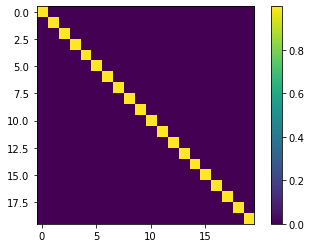

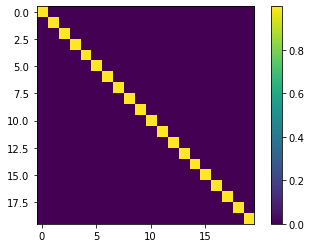

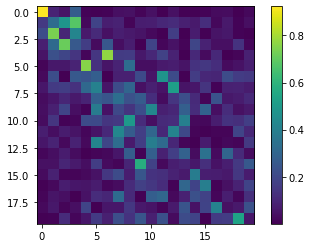

tensor([ 0.9232, -0.3281, -0.0975,  0.2592, -0.0148, -0.1336, -0.0028,  0.2133,
         0.2294,  0.2198,  0.0368, -0.1025, -0.1010,  0.2862, -0.0598,  0.0766,
         0.0082, -0.0771,  0.0641, -0.0572], device='cuda:0',
       grad_fn=<DiagBackward0>)


In [7]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(np.abs((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy()))
plt.colorbar()
plt.show()

print(torch.diag((features1 @ Q1).T @ (features2 @ Q2)))

In [8]:
for g in optimizerCCA.param_groups:
      g['lr'] = g['lr'] / 10
      g['lambda_regul'] = g['lambda_regul']

In [9]:
for epoch in range(20):
    model1.eval()
    model2.eval()
    train_loss = 0
    dist1 = torch.zeros(p,p, device = device)
    dist2 = torch.zeros(p,p, device = device)
    for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        with torch.no_grad():
            _ = model1(batch_x)
            _ = model2(batch_x)
            features1 = activation['features1'].view((activation['features1'].shape[0],-1))
            features2 = activation['features2'].view((activation['features2'].shape[0],-1))
            features1 = (features1 - torch.mean(features1, dim=0))
            features2 = (features2 - torch.mean(features2, dim=0))
        loss = -torch.trace( (Q1.T @ features1.T) @ (features2 @ Q2)) /  (batch_x.size(0))
        train_loss =+ loss.item() * batch_x.size(0)
        dist1 += (features1 @ Q1).T @ (features1 @ Q1) 
        dist2 += (features2 @ Q2).T @ (features2 @ Q2)
        optimizerCCA.zero_grad()
        loss.backward()
        optimizerCCA.step(((features1, features2 ),))
    print('Objective: %2.5f' % train_loss)
    print('Dist Q1: %2.5f' % (torch.linalg.norm(dist1 - torch.eye(p,p, device = device)).item() / len(trainloader)))
    print('Dist Q2: %2.5f' % (torch.linalg.norm(dist2 - torch.eye(p,p, device = device)).item() /len(trainloader)) )

Objective: -9.61416
Dist Q1: 3.65003
Dist Q2: 3.80091
Objective: -11.50668
Dist Q1: 3.65394
Dist Q2: 3.85008
Objective: -12.63437
Dist Q1: 3.65651
Dist Q2: 3.83800
Objective: -13.01447
Dist Q1: 3.65966
Dist Q2: 3.82516
Objective: -13.49870
Dist Q1: 3.66194
Dist Q2: 3.81374
Objective: -13.58173
Dist Q1: 3.66460
Dist Q2: 3.80699
Objective: -13.77267
Dist Q1: 3.66724
Dist Q2: 3.80016
Objective: -13.37390
Dist Q1: 3.66966
Dist Q2: 3.79381
Objective: -13.87409
Dist Q1: 3.67225
Dist Q2: 3.78871
Objective: -13.73200
Dist Q1: 3.67494
Dist Q2: 3.78571
Objective: -13.83156
Dist Q1: 3.67704
Dist Q2: 3.78237
Objective: -13.64179
Dist Q1: 3.68011
Dist Q2: 3.77989
Objective: -13.66645
Dist Q1: 3.68256
Dist Q2: 3.77719
Objective: -13.82600
Dist Q1: 3.68515
Dist Q2: 3.77541
Objective: -13.63936
Dist Q1: 3.68733
Dist Q2: 3.77366
Objective: -13.83434
Dist Q1: 3.68974
Dist Q2: 3.77330
Objective: -13.85437
Dist Q1: 3.69237
Dist Q2: 3.77259
Objective: -13.80661
Dist Q1: 3.69492
Dist Q2: 3.77249
Objective: 

In [3]:
def VectorizeImage(batch):
    data = [item[0].view(-1).unsqueeze(1)[:500] for item in batch]
    return(torch.cat(data, dim = 1))

loader_A = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=VectorizeImage)

In [6]:
LandingCCA(iter(loader_A), iter(loader_A), p = 10, learning_rate = 1e-3, lambda_regul = 1,  n_epochs=5, device = 'cuda')

KeyboardInterrupt: 

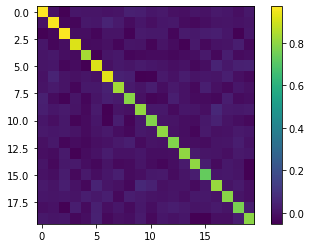

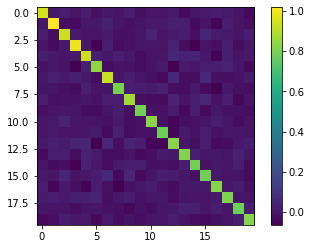

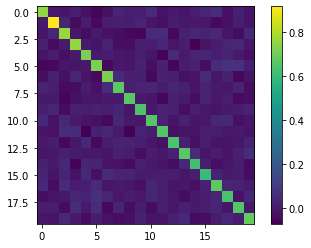

In [10]:
plt.imshow(dist1.cpu().detach().numpy()/len(trainloader))
plt.colorbar()
plt.show()

plt.imshow(dist2.cpu().detach().numpy()/len(trainloader))
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

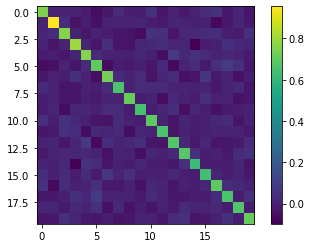

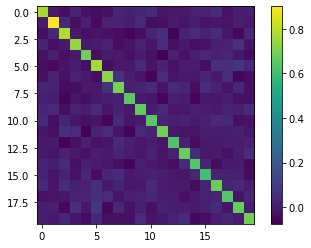

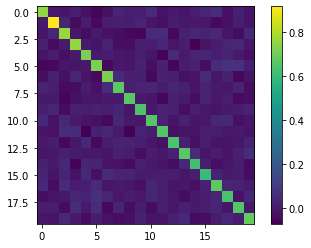

In [12]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
torch.diag(Q1.T @ features1.T@ features2 @ Q2).sum()

tensor(25.3942, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
torch.linalg.norm(features1 @ features2.T)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (848x32768 and 16384x848)

In [ ]:
torch.linalg.norm(features1 @ Q1 @ Q2.T @ features2.T)

tensor(1.7435, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
(features1 @ Q1 @ Q2.T @ features2.T).shape

torch.Size([80, 80])

In [ ]:
(features1 @ features2.T).shape

torch.Size([80, 80])

In [217]:
x_true = B_sqrt_inv  @ uG[:,:p]

NameError: name 'B_sqrt_inv' is not defined

In [204]:
torch.linalg.norm((features1 @ Q1).T @ (features1 @ Q1) - torch.eye(p,p, device = device))

tensor(4.3785, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [218]:
torch.diag((features1 @ Q1).T @ (features2 @ Q2))

tensor([0.3751, 0.4544, 0.3530, 0.4672, 0.3098, 0.4153, 0.3651, 0.4537, 0.3104,
        0.4110, 0.4458, 0.3260, 0.3644, 0.4497, 0.4044, 0.4983, 0.4550, 0.3374,
        0.3649, 0.3223, 0.4536, 0.3510, 0.5946, 0.3729, 0.4212, 0.4352, 0.5927,
        0.4242, 0.3799, 0.4061, 0.4219, 0.4915, 0.3397, 0.4305, 0.4621, 0.5205,
        0.3581, 0.3714, 0.3048, 0.3836], device='cuda:0',
       grad_fn=<DiagBackward0>)

In [219]:
torch.trace( (features1).T @ features2 )

tensor(-17784.1172, device='cuda:0')

In [321]:
torch.trace( (features1 @ Q1).T @ features2 @ Q2) / 40

tensor(0.6224, device='cuda:0', grad_fn=<DivBackward0>)

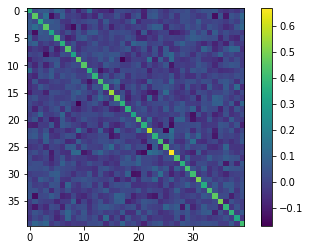

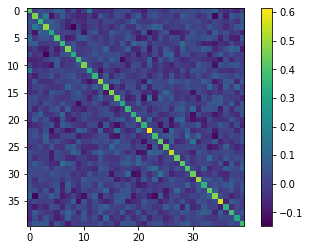

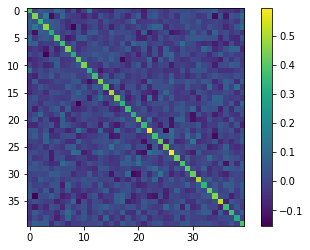

In [221]:
plt.imshow((Q2.T @ features2.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features1 @ Q1).cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow((Q1.T @ features1.T@ features2 @ Q2).cpu().detach().numpy())
plt.colorbar()
plt.show()

In [246]:
torch.trace(Q1.T @ features1.T@ features2 @ Q2)

tensor(6.8522, device='cuda:0', grad_fn=<TraceBackward0>)

In [19]:
(features1 @ Q1).T @ 

torch.Size([80, 40])

In [53]:
D1 = (features1 @ Q1).cpu().detach().numpy()
D2 = (features2 @ Q2).cpu().detach().numpy()

D1 = (D1 - D1.mean(axis=0)) #  / D1.std(axis=0) 
D2 = (D2 - D2.mean(axis=0)) # / D2.std(axis=0)
Cov12 = D1.T @ D2 / D1.shape[0]


In [55]:
from scipy.stats import pearsonr

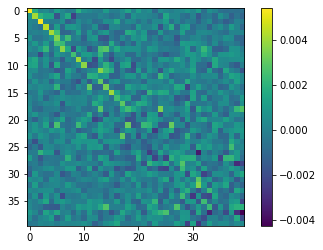

In [54]:
plt.imshow(Cov12 / ())
plt.colorbar()

In [56]:
torch.corrcoef((features1 @ Q1).T, (features2 @ Q2).T)

TypeError: corrcoef() takes 1 positional argument but 2 were given

In [17]:
Q1.shape

torch.Size([32768, 40])

In [244]:
(features1 * features1).sum()

tensor(2588672., device='cuda:0')

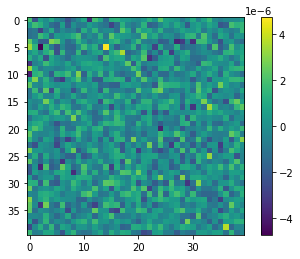

In [245]:
plt.imshow((Q1.T @ Q2).cpu().detach().numpy())
plt.colorbar()

In [17]:
for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        with torch.no_grad():
            features1 = model1.features(batch_x).squeeze()
            features2 = model2.features(batch_x).squeeze()
        covXY += features1.T @ features2 / batch_x.size(0)
        covX += features1.T @ features1 / batch_x.size(0)
        covY += features2.T @ features2 / batch_x.size(0)

In [41]:
len(trainloader.dataset)

50000

In [18]:
loss = -.5*torch.trace( Q1.T @ features1.T @ features2 @ Q2)

In [22]:
loss.backward()

In [23]:
optimizerCCA.step(((features1.T@ features1, features2.T@ features2),))

In [25]:
train_loss =+ loss.item() * batch_x.size(0)

In [34]:
loss.item()

-0.34627026319503784

In [36]:
-.5*torch.trace( Q1.T @ features1.T @ features2 @ Q2)

tensor(-0.3463, device='cuda:0', grad_fn=<MulBackward0>)

In [18]:
trainloader_enum = enumerate(trainloader)

In [33]:
i, (batch_x, batch_y) = trainloader_enum.__next__()
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

In [87]:
A1 = model1.features(batch_x)[:,:,0,0].cpu().detach().numpy()
A2 = model1.features(batch_x)[:,:,0,0].cpu().detach().numpy()

In [142]:
n = 512
p = 10
Q1 = torch.randn(n, p, device = device, requires_grad=True)
Q2 = torch.randn(n, p, device = device, requires_grad=True)

In [145]:
optimizer_cca = optim.SGD((Q1, Q2), lr=1e-6)

In [147]:
best_test_acc = 0.
model1.eval()
model2.eval()
for epoch in range(n_epochs):
    train_loss = 0.0
    for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        A1 = model1.features(batch_x)[:,:,0,0].detach()
        A2 = model2.features(batch_x)[:,:,0,0].detach()
        loss = - torch.trace(Q1.T@ (A1.T @ A2) @ Q2)
        train_loss =+ loss.item() * batch_x.size(0)
        optimizer_cca.zero_grad()
        loss.backward()
        optimizer_cca.step()
        with torch.no_grad():
            Q1,_ = torch.linalg.qr(Q1)
            Q2,_ = torch.linalg.qr(Q2)
        Q1.requires_grad = True
        Q2.requires_grad = True
    print(train_loss/len(trainset))

-11.53541328125
-12.8180953125
-10.70384453125
-10.55670625
-10.276184375
-11.49911875
-10.47547421875
-10.5956484375
-9.82373359375
-9.57715546875
-10.41351875
-10.265225
-10.7919796875
-10.0132453125
-9.96588125


In [139]:
Q1.T@Q1

tensor([[ 1.0000e+00,  5.5879e-09, -2.7940e-09, -9.3132e-09,  9.3132e-10,
          4.6566e-09, -8.8476e-09, -1.2107e-08, -1.9558e-08, -5.5879e-09],
        [ 5.5879e-09,  1.0000e+00,  3.2596e-09,  1.1642e-09,  6.7521e-09,
          3.7253e-09, -5.1223e-09, -1.8626e-09, -2.7940e-09,  1.0245e-08],
        [-2.7940e-09,  3.2596e-09,  1.0000e+00, -2.3283e-10, -8.3819e-09,
          4.1910e-09, -1.3970e-08, -3.2596e-09, -9.3132e-10, -6.5193e-09],
        [-9.3132e-09,  1.1642e-09, -2.3283e-10,  1.0000e+00, -1.5600e-08,
          0.0000e+00,  1.8626e-09,  4.6566e-10,  2.3283e-10,  4.6566e-10],
        [ 9.3132e-10,  6.7521e-09, -8.3819e-09, -1.5600e-08,  1.0000e+00,
         -4.6566e-10, -8.3819e-09,  4.6566e-09,  5.5879e-09,  3.7253e-09],
        [ 4.6566e-09,  3.7253e-09,  4.1910e-09,  0.0000e+00, -4.6566e-10,
          1.0000e+00,  2.4680e-08,  2.7940e-09, -5.5879e-09,  3.2596e-09],
        [-8.8476e-09, -5.1223e-09, -1.3970e-08,  1.8626e-09, -8.3819e-09,
          2.4680e-08,  1.0000e+0

In [89]:
from sklearn.cross_decomposition import CCA

In [96]:
cca = CCA(n_components=10)
cca.fit(A1, A2)

CCA(n_components=10)

In [99]:
cca.score(A1, A2)

0.5813387144987419

In [92]:
X_c, Y_c = cca.transform(A1, A2)

In [75]:
(U, S, V) = torch.pca_lowrank(A1.T@A2, q = 100, center=True, niter=20)

In [84]:
S.cpu().detach().numpy()[:50]

array([1.0347093e+04, 5.0820493e+03, 3.5821323e+03, 2.9084653e+03,
       2.4939863e+03, 1.8302538e+03, 1.3989786e+03, 1.1476134e+03,
       8.5155157e+02, 6.2643530e+02, 2.4559721e+02, 7.1573997e+01,
       5.0670170e+01, 4.8174137e+01, 4.1952473e+01, 3.7283165e+01,
       3.6203281e+01, 3.1056530e+01, 2.5350792e+01, 2.4845078e+01,
       2.2801348e+01, 2.0585983e+01, 1.9518456e+01, 1.7976635e+01,
       1.6180603e+01, 1.5687751e+01, 1.3683533e+01, 1.2015533e+01,
       1.0651150e+01, 1.0012889e+01, 9.1580162e+00, 8.3238554e+00,
       7.8208060e+00, 7.5031281e+00, 6.8287992e+00, 6.1659822e+00,
       5.9519992e+00, 5.1096954e+00, 4.9533033e+00, 4.3717241e+00,
       4.1098890e+00, 3.8927417e+00, 3.5315640e+00, 3.5272615e+00,
       3.4553266e+00, 3.2666328e+00, 3.1249063e+00, 3.0096223e+00,
       2.7635863e+00, 2.6369815e+00], dtype=float32)

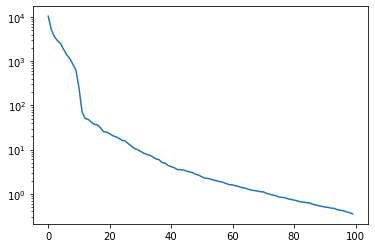

In [82]:
plt.semilogy(S.cpu().detach().numpy())

In [69]:
A1.shape

torch.Size([128, 512])

In [23]:
trainloader.batch_size

128

In [32]:
batch_x.shape

torch.Size([128, 3, 32, 32])